In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn.utils import class_weight

In [2]:
train_df = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv',header=None)
test_df = pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv',header=None)

In [3]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
target_column_index = train_df.columns[-1]  

class_names = {
    0: "Normal Beats",
    1: "Supraventricular Ectopy Beats",
    2: "Ventricular Ectopy Beats",
    3: "Fusion Beats",
    4: "Unclassifiable Beats"
}

for label in train_df[target_column_index].unique():
    print(f"Class label {label}: {class_names.get(label, 'Unknown Label')}")

Class label 0.0: Normal Beats
Class label 1.0: Supraventricular Ectopy Beats
Class label 2.0: Ventricular Ectopy Beats
Class label 3.0: Fusion Beats
Class label 4.0: Unclassifiable Beats


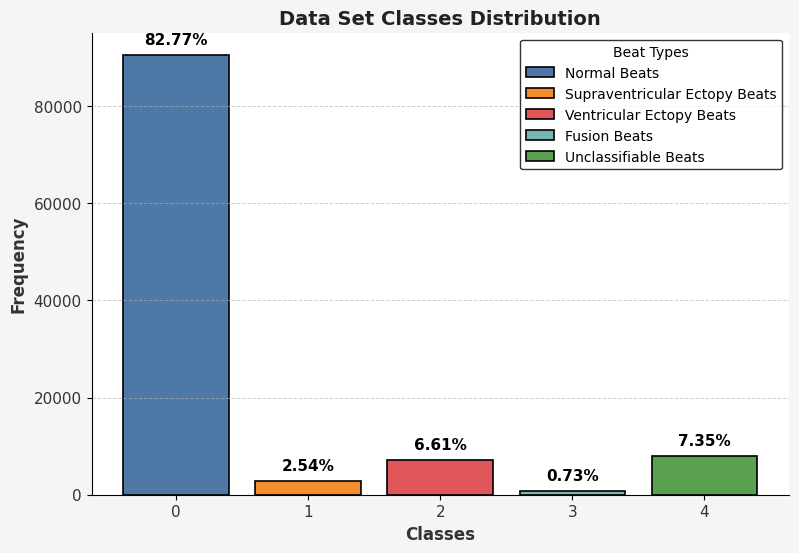

In [5]:
data = (train_df[187].value_counts() + test_df[187].value_counts()).sort_index()

label_mapping = {
    0: "Normal Beats",
    1: "Supraventricular Ectopy Beats",
    2: "Ventricular Ectopy Beats",
    3: "Fusion Beats",
    4: "Unclassifiable Beats"
}

colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F']

total = data.sum()
percentages = (data / total * 100).round(2)

plt.figure(figsize=(9, 6), facecolor='#F5F5F5')  # Light gray background
bars = plt.bar(data.index, data.values, color=colors[:len(data)], edgecolor='black', linewidth=1.2)

for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + total * 0.02, 
             f"{percentage:.2f}%", ha='center', fontsize=11, fontweight='bold', color='black')

plt.legend(bars, [label_mapping.get(int(c), "Unknown") for c in data.index], title="Beat Types", 
           fontsize=10, frameon=True, edgecolor='black', loc="upper right")


plt.xlabel("Classes", fontsize=12, fontweight='bold', color='#333333')
plt.ylabel("Frequency", fontsize=12, fontweight='bold', color='#333333')
plt.title("Data Set Classes Distribution", fontsize=14, fontweight='bold', color='#222222')

plt.xticks(data.index, fontsize=11, color='#333333')
plt.yticks(fontsize=11, color='#333333')

plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.show()


In [6]:
df_dict = {label: train_df[train_df[187] == label] for label in range(1, 5)}

df_1 = df_dict[1]
df_2 = df_dict[2]
df_3 = df_dict[3]
df_4 = df_dict[4]

In [7]:
from sklearn.utils import resample

n_samples = 20000
random_seed = 3112

df_balanced = [train_df[train_df[187] == 0].sample(n=n_samples, random_state=random_seed)] + [
    resample(train_df[train_df[187] == label], 
             n_samples=n_samples, 
             replace=True, 
             random_state=random_seed) 
    for label in range(1, 5)
]

train_df = pd.concat(df_balanced, ignore_index=True)


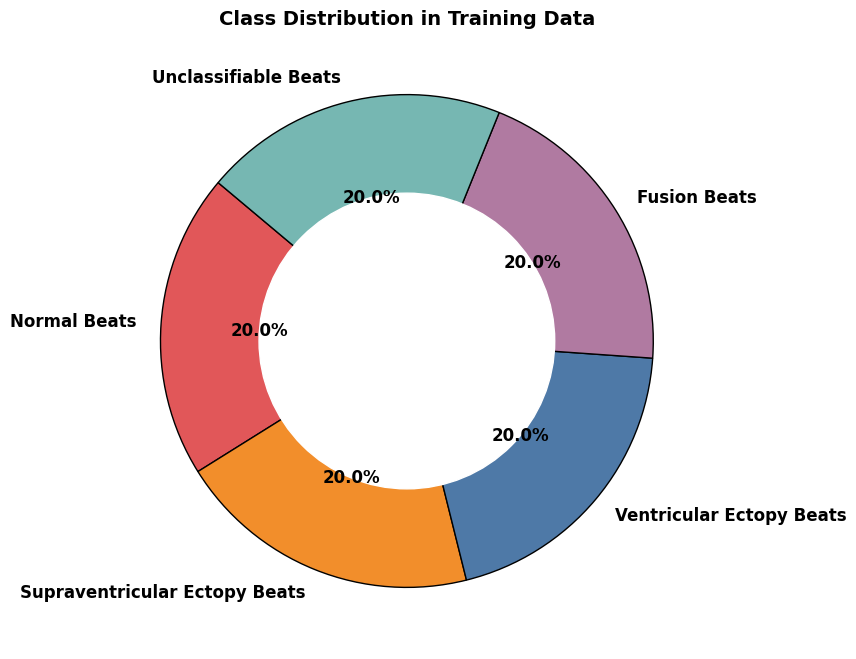

In [8]:
import matplotlib.pyplot as plt

labels = ['Normal Beats', 'Supraventricular Ectopy Beats', 'Ventricular Ectopy Beats', 'Fusion Beats', 'Unclassifiable Beats']
colors = ['#E15759', '#F28E2B', '#4E79A7', '#B07AA1', '#76B7B2']

class_counts = train_df[187].value_counts().sort_index()

plt.figure(figsize=(8, 8), facecolor='white')
wedges, texts, autotexts = plt.pie(
    class_counts, labels=labels, autopct='%0.1f%%', colors=colors,
    startangle=140, wedgeprops={'edgecolor': 'black'}, textprops={'fontsize': 12, 'weight': 'bold'}
)

plt.gca().add_artist(plt.Circle((0, 0), 0.6, color='white'))

plt.title("Class Distribution in Training Data", fontsize=14, fontweight='bold')
plt.show()


In [9]:
class_counts = train_df[187].value_counts()

print("Class Distribution:\n", class_counts)
print("\nNumber of Unique Classes:", len(class_counts))

Class Distribution:
 187
0.0    20000
1.0    20000
2.0    20000
3.0    20000
4.0    20000
Name: count, dtype: int64

Number of Unique Classes: 5


In [10]:
df_t_dict = {label: test_df[test_df[187] == label] for label in range(1, 5)}

df_1_t = df_t_dict[1]
df_2_t = df_t_dict[2]
df_3_t = df_t_dict[3]
df_4_t = df_t_dict[4]

In [11]:
from sklearn.utils import resample
import pandas as pd

n_samples = 5000
random_seed = 123

df_balanced_t = [test_df[test_df[187] == 0].sample(n=n_samples, random_state=random_seed)] + [
    resample(test_df[test_df[187] == label], 
             n_samples=n_samples, 
             replace=True, 
             random_state=random_seed) 
    for label in range(1, 5)
]

test_df = pd.concat(df_balanced_t, ignore_index=True)

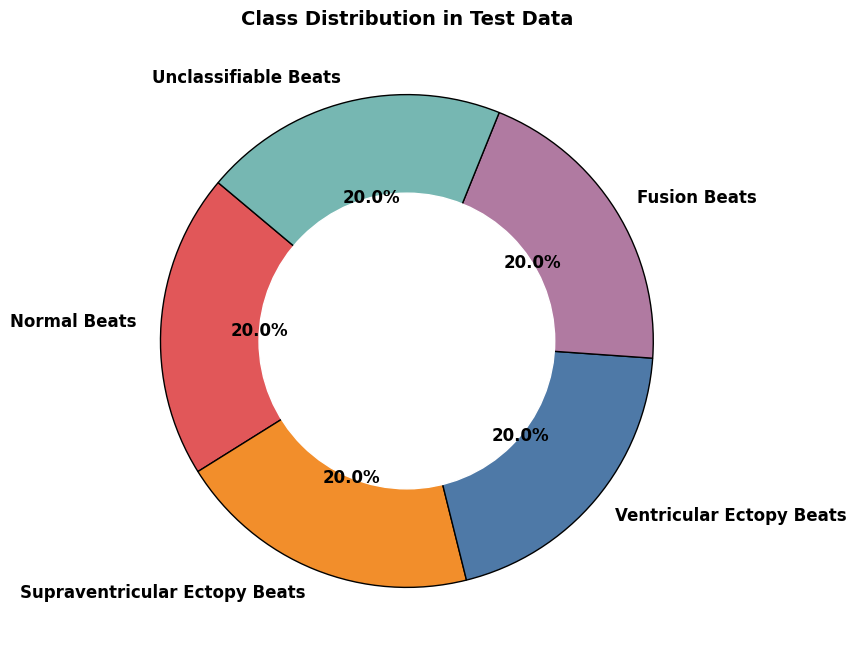

In [12]:
import matplotlib.pyplot as plt

labels = ['Normal Beats', 'Supraventricular Ectopy Beats', 'Ventricular Ectopy Beats', 'Fusion Beats', 'Unclassifiable Beats']
colors = ['#E15759', '#F28E2B', '#4E79A7', '#B07AA1', '#76B7B2']

class_counts = test_df[187].value_counts().sort_index()

plt.figure(figsize=(8, 8), facecolor='white')
wedges, texts, autotexts = plt.pie(
    class_counts, labels=labels, autopct='%0.1f%%', colors=colors,
    startangle=140, wedgeprops={'edgecolor': 'black'}, textprops={'fontsize': 12, 'weight': 'bold'}
)

plt.gca().add_artist(plt.Circle((0, 0), 0.6, color='white'))

plt.title("Class Distribution in Test Data", fontsize=14, fontweight='bold')
plt.show()

In [13]:
X_train = train_df.drop(columns = [187])
y_train = train_df[187]

In [14]:
from scipy.signal import butter, filtfilt

sampling_rate = 125
cutoff_frequency = 50

def butter_lowpass_filter(data, cutoff_freq, fs, order=5):
    nyquist_freq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data, axis=1)  # Apply filtering along the time axis

filtered_ecg_signal = butter_lowpass_filter(X_train, cutoff_frequency, sampling_rate)


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_valid_normalized = scaler.transform(X_valid)
X_test_normalized = scaler.transform(X_test)

X_train_normalized_df = pd.DataFrame(X_train_normalized, columns=X_train.columns)

print("Before Normalization:")
print(X_train.head(5))

print("\nAfter Normalization (First 5 Rows):")
print(X_train_normalized_df.head(5))


Before Normalization:
            0         1         2         3         4         5         6    \
75220  0.722117  1.000000  0.739130  0.308129  0.189036  0.160681  0.147448   
48955  0.000000  0.020000  0.098000  0.202000  0.292000  0.316000  0.318000   
44966  0.998828  1.000000  0.966002  0.914420  0.910903  0.868699  0.773740   
13568  1.000000  0.871622  0.652027  0.246622  0.074324  0.033784  0.030405   
92727  0.949219  0.550781  0.546875  0.535156  0.539062  0.511719  0.503906   

            7         8         9    ...  177  178  179  180  181  182  183  \
75220  0.130435  0.126654  0.122873  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
48955  0.340000  0.400000  0.524000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
44966  0.622509  0.381008  0.295428  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
13568  0.010135  0.016892  0.006757  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
92727  0.457031  0.371094  0.250000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       184  185  186  
75220

In [16]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.972452,0.785124,0.289256,0.035813,0.049587,0.068871,0.019284,0.000000,0.008264,0.008264,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.994595,0.936937,0.600000,0.430631,0.385586,0.365766,0.300901,0.270270,0.227027,0.190991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.921811,0.633745,0.144033,0.057613,0.098765,0.086420,0.053498,0.037037,0.020576,0.024691,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.980645,0.580645,0.178495,0.092473,0.126882,0.141935,0.133333,0.120430,0.131183,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.812834,0.454545,0.000000,0.136364,0.304813,0.371658,0.419786,0.374332,0.360963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print(train_df.shape)
print(test_df.shape)

(100000, 188)
(25000, 188)


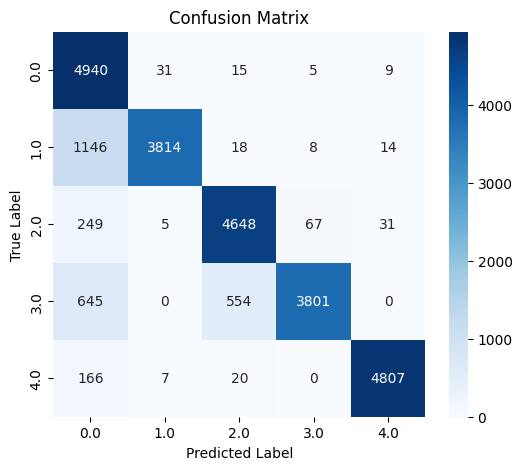

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_normalized, y_train)

y_pred_test = model.predict(X_test_normalized)

cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [22]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

CNN_model = Sequential()

CNN_model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(187, 1)))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling1D(pool_size=2))

CNN_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling1D(pool_size=2))

CNN_model.add(Flatten())

CNN_model.add(Dense(128, activation='relu'))
CNN_model.add(Dropout(0.3))

CNN_model.add(Dense(5, activation='softmax'))

CNN_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

CNN_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 183, 64)             │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 183, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 91, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 87, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 87, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 43, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5504)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         704,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 747,525 (2.85 MB)

 Trainable params: 747,141 (2.85 MB)

 Non-trainable params: 384 (1.50 KB)

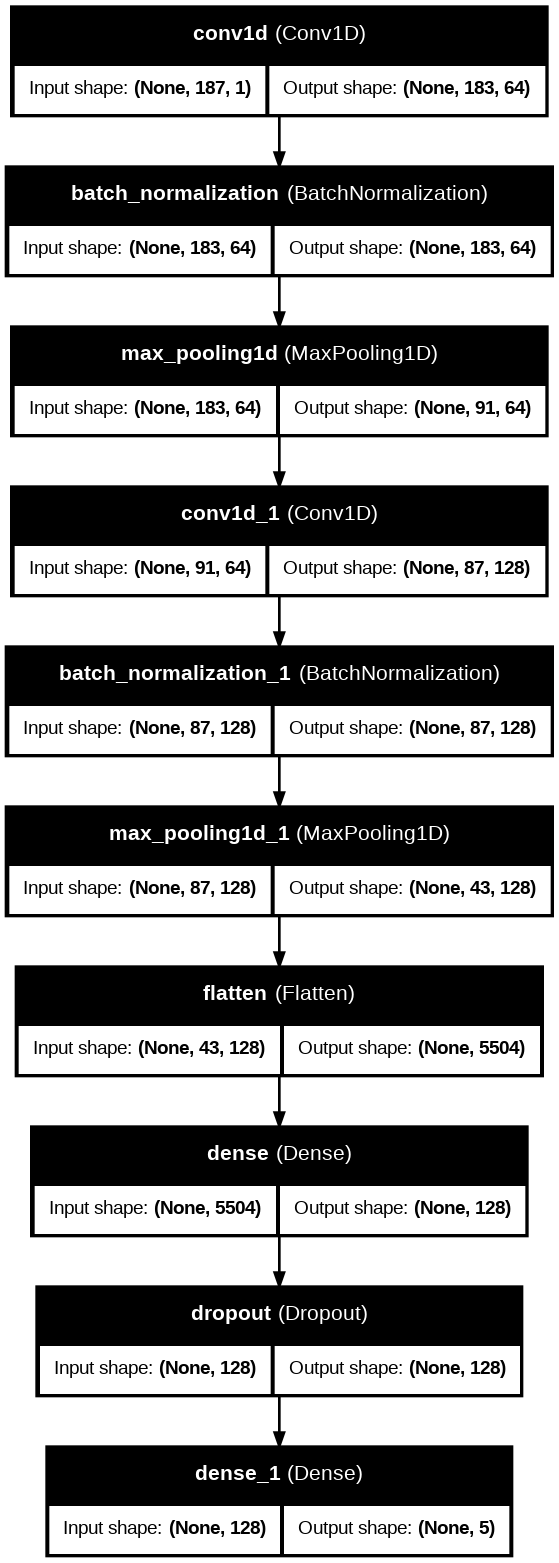

In [23]:
from tensorflow.keras.utils import plot_model

plot_model(CNN_model, to_file='CNN_model_plot.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)


In [24]:
history_CNN = CNN_model.fit(X_train_normalized.reshape(-1, 187, 1), y_train,  
                            epochs=150,  
                            batch_size=128,  
                            validation_data=(X_valid_normalized.reshape(-1, 187, 1), y_valid),  
                            callbacks=[early_stopping],  
                            verbose=1)

loss, accuracy = CNN_model.evaluate(X_valid_normalized.reshape(-1, 187, 1), y_valid)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


Epoch 1/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8396 - loss: 0.5327 - val_accuracy: 0.9528 - val_loss: 0.1407
Epoch 2/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9497 - loss: 0.1392 - val_accuracy: 0.9694 - val_loss: 0.0927
Epoch 3/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9674 - loss: 0.0904 - val_accuracy: 0.9829 - val_loss: 0.0528
Epoch 4/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9781 - loss: 0.0636 - val_accuracy: 0.9851 - val_loss: 0.0446
Epoch 5/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9826 - loss: 0.0513 - val_accuracy: 0.9859 - val_loss: 0.0462
Epoch 6/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9857 - loss: 0.0424 - val_accuracy: 0.9885 - val_loss: 0.0405
Epoch 7/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9875 - loss: 0.0371 - val_accuracy: 0.9902 - val_loss: 0.0383
Epoch 8/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9873 - loss: 0.0352 - val_accu

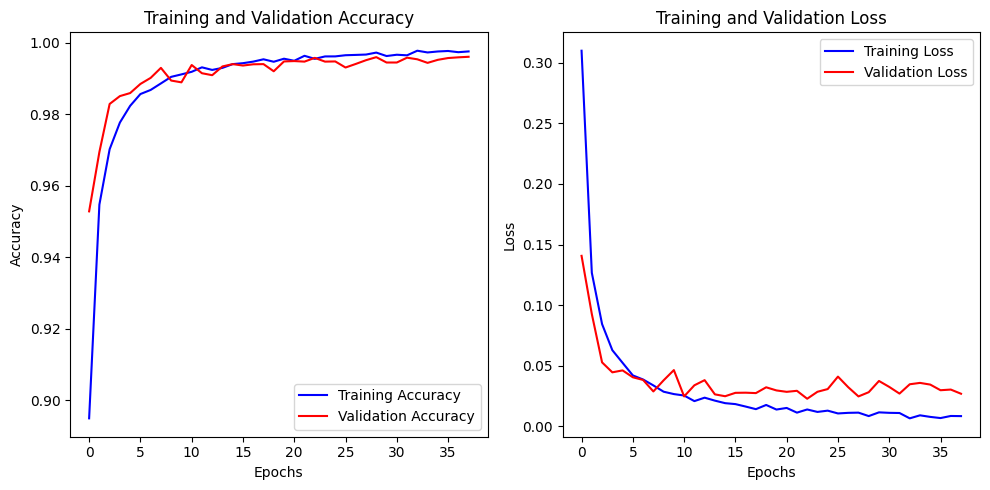

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_CNN.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history_CNN.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_CNN.history['loss'], label='Training Loss', color='blue')
plt.plot(history_CNN.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


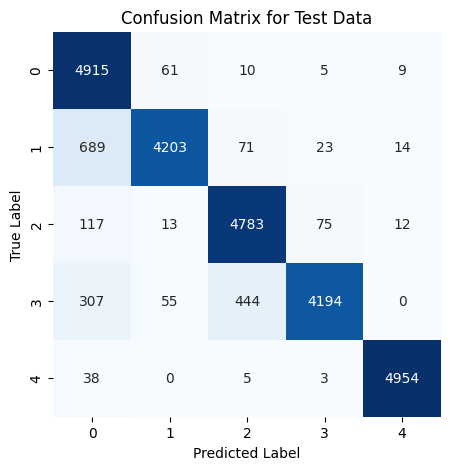

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import numpy as np

y_pred_test_prob = CNN_model.predict(X_test_normalized)
y_pred_test_classes = np.argmax(y_pred_test_prob, axis=1)  

encoder = OneHotEncoder(sparse=False)

y_test_reshaped = y_test.to_numpy().reshape(-1, 1)

y_test_onehot = encoder.fit_transform(y_test_reshaped)

y_test_classes = np.argmax(y_test_onehot, axis=1)

conf_matrix = confusion_matrix(y_test_classes, y_pred_test_classes)

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Test Data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


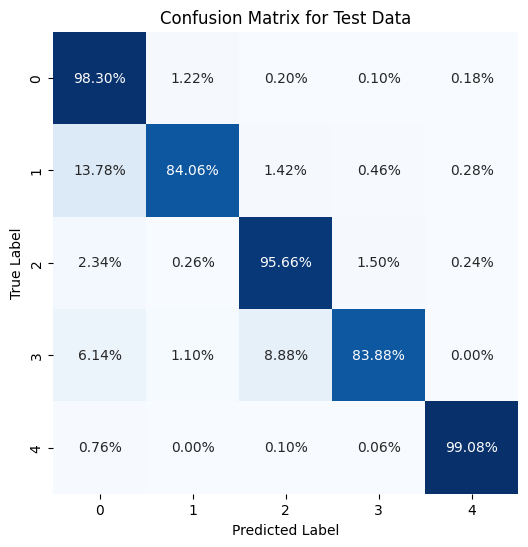

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test_classes, y_pred_test_classes)

conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2%", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Test Data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [40]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_test_classes, y_pred_test_classes)

print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9220


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class ECGTransformer(nn.Module):
    def __init__(self, input_dim=187, num_classes=5, embed_dim=128, num_heads=4, ff_dim=256, num_layers=2, dropout=0.1):
        super(ECGTransformer, self).__init__()

        self.embedding = nn.Linear(input_dim, embed_dim)

        encoder_layers = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=num_heads, 
            dim_feedforward=ff_dim, 
            dropout=dropout, 
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        self.fc = nn.Linear(embed_dim, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.dropout(x)
        x = self.fc(x)
        return self.softmax(x)


In [36]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32).unsqueeze(1)  # (batch, sequence, feature)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_valid_tensor = torch.tensor(X_valid_normalized, dtype=torch.float32).unsqueeze(1)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ECGTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss, correct = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_accuracy = correct / len(train_dataset)
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    model.eval()
    valid_loss, correct = 0, 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

    valid_accuracy = correct / len(valid_dataset)
    valid_losses.append(valid_loss / len(valid_loader))
    valid_accuracies.append(valid_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
          f"Val Loss: {valid_losses[-1]:.4f}, Val Acc: {valid_accuracies[-1]:.4f}")


Epoch 1/50, Train Loss: 1.1043, Train Acc: 0.8033, Val Loss: 1.0443, Val Acc: 0.8606
Epoch 2/50, Train Loss: 1.0430, Train Acc: 0.8615, Val Loss: 1.0308, Val Acc: 0.8741
Epoch 3/50, Train Loss: 1.0282, Train Acc: 0.8759, Val Loss: 1.0085, Val Acc: 0.8965
Epoch 4/50, Train Loss: 1.0150, Train Acc: 0.8895, Val Loss: 1.0143, Val Acc: 0.8911
Epoch 5/50, Train Loss: 1.0073, Train Acc: 0.8972, Val Loss: 0.9982, Val Acc: 0.9069
Epoch 6/50, Train Loss: 1.0019, Train Acc: 0.9024, Val Loss: 0.9912, Val Acc: 0.9143
Epoch 7/50, Train Loss: 0.9937, Train Acc: 0.9107, Val Loss: 0.9853, Val Acc: 0.9194
Epoch 8/50, Train Loss: 0.9916, Train Acc: 0.9127, Val Loss: 0.9867, Val Acc: 0.9190
Epoch 9/50, Train Loss: 0.9879, Train Acc: 0.9167, Val Loss: 0.9933, Val Acc: 0.9115
Epoch 10/50, Train Loss: 0.9859, Train Acc: 0.9184, Val Loss: 0.9858, Val Acc: 0.9185
Epoch 11/50, Train Loss: 0.9827, Train Acc: 0.9219, Val Loss: 0.9790, Val Acc: 0.9258
Epoch 12/50, Train Loss: 0.9812, Train Acc: 0.9231, Val Loss: 0

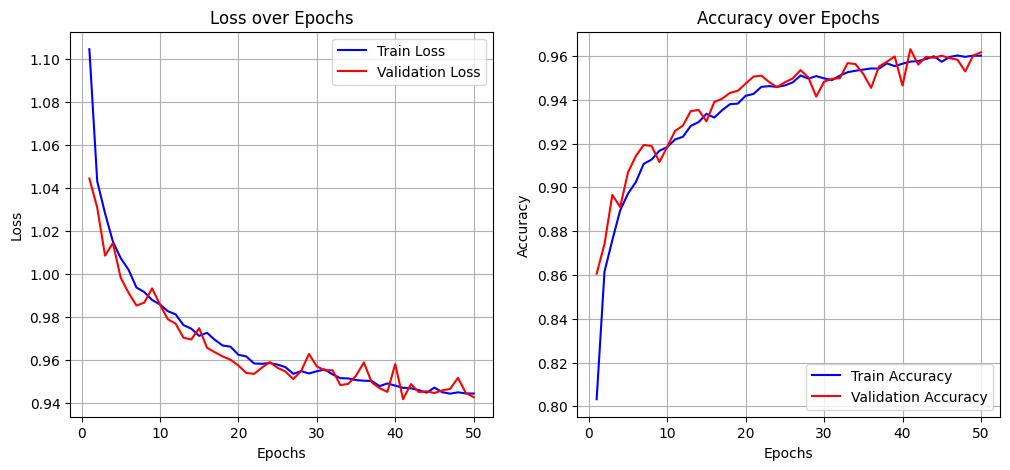

In [43]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, valid_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
plt.plot(epochs, valid_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid()

plt.show()


In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = outputs.argmax(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)


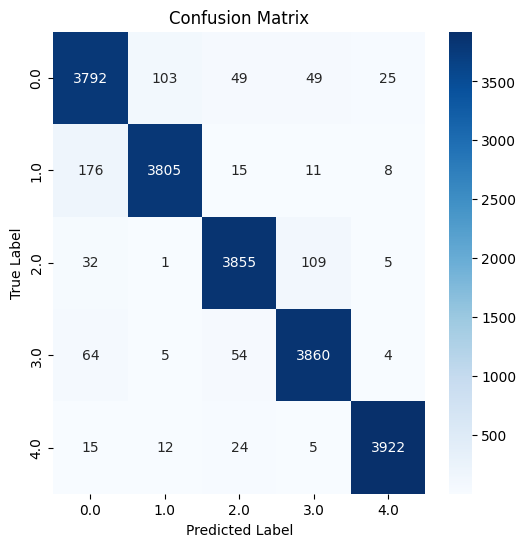

In [45]:
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
